In [100]:
import scregistry
import astropy.units as u
import astropy.io.fits
import astropy.time
import astropy.table
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import fsspec
import sunpy.map

In [82]:
def search_registry(start_date, end_date, wavelength, bucket=None):
    if bucket is None:
        bucket = "s3://gov-nasa-hdrl-data1/"
    file_registry = scregistry.FileRegistry(bucket)
    results =  file_registry.request_file_registry(
        f'aia_{int(wavelength.to_value("angstrom")):04d}',
        start_date=f'{start_date.isot}Z',
        stop_date=f'{end_date.isot}Z',
        overwrite=False
    )
    results = astropy.table.Table.from_pandas(results)
    return results

In [83]:
interval = 12*u.h
midpoint = astropy.time.Time('2018-05-29 18:00:00', scale='utc')

In [84]:
file_list = search_registry(midpoint-interval/2, midpoint+interval/2, 171*u.angstrom)

In [94]:
i_midpoint = np.argmin(np.fabs((file_list['start'] - midpoint).to_value('s')))

In [95]:
with astropy.io.fits.open(file_list['datakey'][i_midpoint], use_fsspec=True, fsspec_kwargs={'anon': True}) as hdul:
    header = hdul[1].header
    data = hdul[1].data
    smap = sunpy.map.Map(data, header)

In [106]:
center = SkyCoord(Tx=-125*u.arcsec, Ty=250*u.arcsec, frame=smap.coordinate_frame)

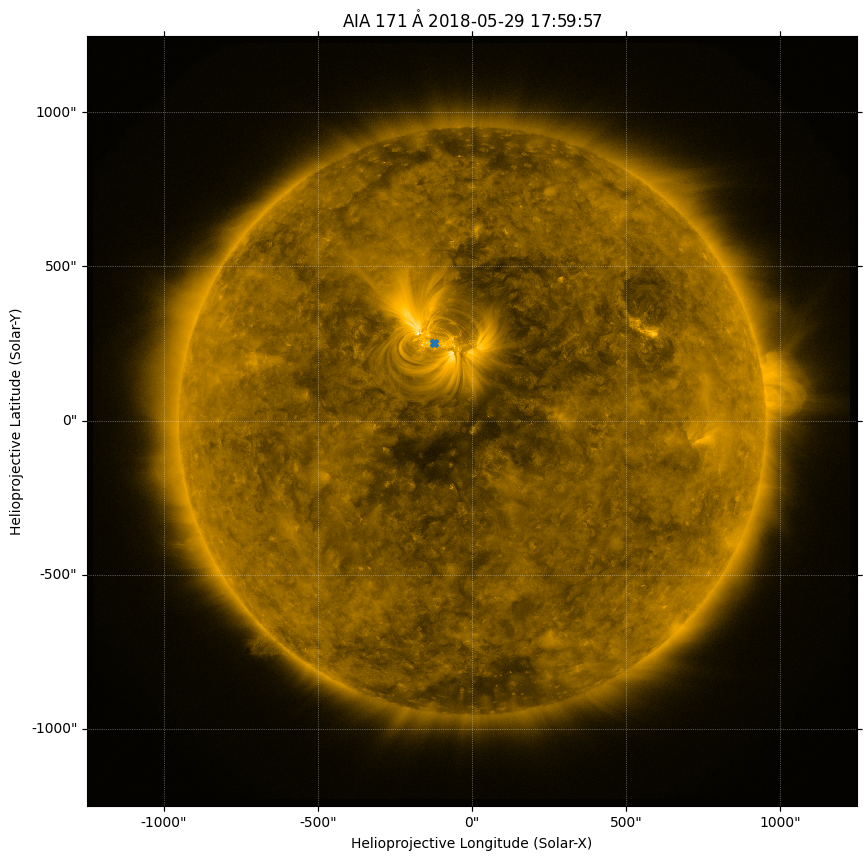

In [107]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=smap)
smap.plot(axes=ax)
ax.plot_coord(center, marker='X', color='C0')

In [115]:
cutout = Cutout2D(smap.data,
                  center,
                  600*u.arcsec,
                  wcs=smap.wcs,)

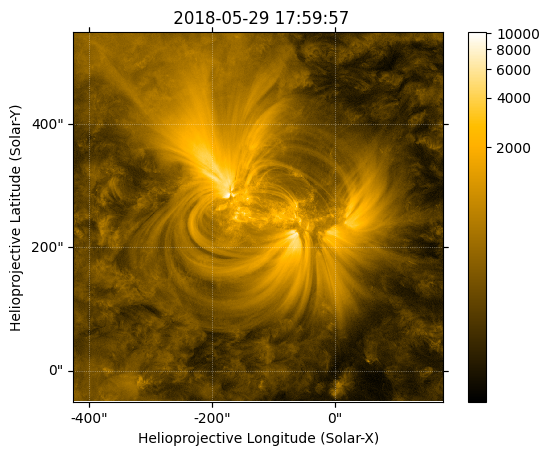

In [116]:
sunpy.map.Map(cutout.data, cutout.wcs, plot_settings=smap.plot_settings).peek()